In [1]:
import pandas as pd
import numpy as np
import json

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier




### Load Dataframes


In [2]:
df_1km = pd.read_csv('Datasets/Machine Learning/Dataframes/1km_All_Birds_DF.csv')
df_5km = pd.read_csv('Datasets/Machine Learning/Dataframes/5km_All_Birds_DF.csv')
df_10km = pd.read_csv('Datasets/Machine Learning/Dataframes/10km_All_Birds_DF.csv')

In [3]:
# Drop random rows with Occurence=0 to even out the dataset
print('Before drop: \n', df_1km.value_counts('Occurrence'))
no_occurences = df_1km[df_1km['Occurrence']==0].index
sample_size = sum(df_1km['Occurrence']==0) - sum(df_1km['Occurrence']==1)
random_indices = np.random.choice(no_occurences, sample_size, replace=False)
df_1km =  df_1km.drop(random_indices)
print('After drop: \n', df_1km.value_counts('Occurrence'))

Before drop: 
 Occurrence
0    210721
1     31995
dtype: int64
After drop: 
 Occurrence
0    31995
1    31995
dtype: int64


### Standardisation

In [4]:
def standardise(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Add headers back
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Revert 'Surface type' back to non-standardised column as it is a categorical feature
    X_scaled_df['Surface type'] = X['Surface type'].values
    return X_scaled_df

### Feature Selection

In [5]:
# nan_columns = []
# for column in X_scaled_df:
#     if X_scaled_df[column].isnull().values.any():
#         nan_columns.append(column)
# print(nan_columns if len(nan_columns)!= 0 else 'None')


# Using ANOVA F-Score as a feature selection method
def feature_select(X, y):
    k_nums = [10, 15, 20, 25, 30, 35]
    kbest_dict = {}
    for num in k_nums:
        # Needs to be 1d array, y.values.ravel() converts y into a 1d array
        best_X = SelectKBest(f_classif, k=num).fit(X, y.values.ravel())
        kbest_dict[str(num)] = best_X.get_feature_names_out().tolist()
    kbest_dict['40'] = list(X.columns)
    # print(json.dumps(kbest_dict, indent=4))

### All three cell sizes

In [6]:
# dfs = [
#     {'name' : '1km', 'dataframe' : df_1km},
#     {'name' : '5km', 'dataframe' : df_5km},
#     {'name' : '10km', 'dataframe' : df_10km}
# ]

# # Look into reading csv with coords as index/multi-index (first two columns)
# estimators = [
#     ('lr', LogisticRegression(max_iter=1000, solver='saga', random_state=42, penalty='l2')),
#     ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
#     ('sgd', SGDClassifier( max_iter=1000, loss='modified_huber', random_state=42, penalty='l2')),
#     ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=42))
# ]


# for data in dfs:
#     print(f'Training with {data["name"]} cells... ')
#     coords, X, y = data['dataframe'].iloc[:, :2], data['dataframe'].iloc[:, 2:-1], data['dataframe'].iloc[:, [-1]]
#     data['coords'] = coords
#     data['X'] = standardise(X)
#     data['y'] = y
#     data['kbest'] = feature_select(X, y)

#     X_train, X_test, y_train, y_test = train_test_split(data['X'], data['y'].values.ravel(), random_state=42)

#     stack_clf = StackingClassifier(
#         estimators=estimators, 
#         final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=42)
#     )

#     stack_clf.fit(X_train, y_train)


#     data['report'] = classification_report(y_test, stack_clf.predict(X_test))
    
#     print(f'Classification report: \n {data["report"]} \n')



### Train-Test Split

In [14]:
# Train test split
coords, X, y = df_5km.iloc[:, :2], df_5km.iloc[:, 2:-1], df_5km.iloc[:, [-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), random_state=42)

### Individual models

In [26]:
# Logistic regression
logreg_clf= LogisticRegression(max_iter=2000, solver='sag', random_state=42, penalty='none', n_jobs=2).fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(logreg_clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(logreg_clf.score(X_test, y_test)))
# f1_score(y_test, logreg_clf.predict(X_test))

y_pred = logreg_clf.predict(X_test)
# print(len(y_pred)==len(y_test))
print(classification_report(y_test, y_pred))

Accuracy score (training): 0.747
Accuracy score (testing): 0.736
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       640
           1       0.74      1.00      0.85      1787

    accuracy                           0.74      2427
   macro avg       0.37      0.50      0.42      2427
weighted avg       0.54      0.74      0.62      2427



c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [8]:
# K Nearest Neigbours
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance').fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(knn_clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(knn_clf.score(X_test, y_test)))
# f1_score(y_test, knn_clf.predict(X_test))

print(classification_report(y_test, knn_clf.predict(X_test)))

Accuracy score (training): 0.996
Accuracy score (testing): 0.651
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      6411
           1       0.65      0.66      0.65      6387

    accuracy                           0.65     12798
   macro avg       0.65      0.65      0.65     12798
weighted avg       0.65      0.65      0.65     12798



In [26]:
sgd_clf = SGDClassifier(loss='modified_huber', max_iter=1000, random_state=42, penalty='l2')
sgd_clf.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(sgd_clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(sgd_clf.score(X_test, y_test)))
# f1_score(y_test, clf1.predict(X_test))
print(classification_report(y_test, sgd_clf.predict(X_test)))

Accuracy score (training): 0.663
Accuracy score (testing): 0.658
              precision    recall  f1-score   support

           0       0.70      0.56      0.62      6411
           1       0.63      0.75      0.69      6387

    accuracy                           0.66     12798
   macro avg       0.66      0.66      0.65     12798
weighted avg       0.66      0.66      0.65     12798



In [27]:
rf_clf = RandomForestClassifier(n_estimators=20,max_features=None, random_state=42)
rf_clf.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(rf_clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(rf_clf.score(X_test, y_test)))
# print("F1-score: {0:.3f}".format(f1_score(y_test, rf_clf.predict(X_test))))
print(classification_report(y_test, rf_clf.predict(X_test)))

Accuracy score (training): 0.994
Accuracy score (testing): 0.676
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      6411
           1       0.68      0.66      0.67      6387

    accuracy                           0.68     12798
   macro avg       0.68      0.68      0.68     12798
weighted avg       0.68      0.68      0.68     12798



In [34]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

lr_list1 = [1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]

lr_list2 = [15, 20, 25, 30, 35, 40] # Not Worth

lr_list3 = np.arange(2.0, 2.15, 0.01)

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=None, max_depth=3, random_state=42)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (testing): {0:.3f}".format(gb_clf.score(X_test, y_test)))
    print(classification_report(y_test, gb_clf.predict(X_test)), '\n')


Learning rate:  0.05
Accuracy score (training): 0.689
Accuracy score (testing): 0.681
              precision    recall  f1-score   support

           0       0.72      0.59      0.65      6411
           1       0.65      0.77      0.71      6387

    accuracy                           0.68     12798
   macro avg       0.69      0.68      0.68     12798
weighted avg       0.69      0.68      0.68     12798
 

Learning rate:  0.075
Accuracy score (training): 0.697
Accuracy score (testing): 0.690
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      6411
           1       0.67      0.75      0.71      6387

    accuracy                           0.69     12798
   macro avg       0.69      0.69      0.69     12798
weighted avg       0.69      0.69      0.69     12798
 

Learning rate:  0.1
Accuracy score (training): 0.697
Accuracy score (testing): 0.694
              precision    recall  f1-score   support

           0       0.71      

### Ensemble Models

In [38]:
# Ensemble learning
estimators = [
    ('lr', LogisticRegression(max_iter=1000, solver='saga', random_state=42, penalty='l2')),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier(loss='modified_huber', max_iter=1000, random_state=42, penalty='l2')),
    ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=42))
]

stack_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=42)
)

stack_clf.fit(X_train, y_train)
print(classification_report(y_test, stack_clf.predict(X_test)), '\n')



c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The ma

              precision    recall  f1-score   support

           0       0.70      0.67      0.68      6411
           1       0.68      0.70      0.69      6387

    accuracy                           0.69     12798
   macro avg       0.69      0.69      0.69     12798
weighted avg       0.69      0.69      0.69     12798
 



In [37]:
estimators = [
    ('lr', LogisticRegression(max_iter=1000, solver='saga', random_state=42, penalty='l2')),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier(loss='modified_huber', max_iter=1000, random_state=42, penalty='l2')),
    ('rf', RandomForestClassifier(n_estimators=20, max_features=None, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=42))
]

vote_clf =  VotingClassifier(estimators)

vote_clf.fit(X_train, y_train)
print(classification_report(y_test, vote_clf.predict(X_test)), '\n')

              precision    recall  f1-score   support

           0       0.71      0.65      0.68      6411
           1       0.68      0.73      0.70      6387

    accuracy                           0.69     12798
   macro avg       0.69      0.69      0.69     12798
weighted avg       0.69      0.69      0.69     12798
 



## Plot Graphs

array([[<AxesSubplot: title={'center': 'Deciduous woodland'}>,
        <AxesSubplot: title={'center': 'Coniferous woodland'}>,
        <AxesSubplot: title={'center': 'Arable'}>,
        <AxesSubplot: title={'center': 'Improve grassland'}>],
       [<AxesSubplot: title={'center': 'Neutral grassland'}>,
        <AxesSubplot: title={'center': 'Calcareous grassland'}>,
        <AxesSubplot: title={'center': 'Acid grassland'}>,
        <AxesSubplot: title={'center': 'Fen'}>],
       [<AxesSubplot: title={'center': 'Heather'}>,
        <AxesSubplot: title={'center': 'Heather grassland'}>,
        <AxesSubplot: title={'center': 'Bog'}>,
        <AxesSubplot: title={'center': 'Inland rock'}>],
       [<AxesSubplot: title={'center': 'Saltwater'}>,
        <AxesSubplot: title={'center': 'Freshwater'}>,
        <AxesSubplot: title={'center': 'Supralittoral rock'}>,
        <AxesSubplot: title={'center': 'Supralittoral sediment'}>],
       [<AxesSubplot: title={'center': 'Littoral rock'}>,
       

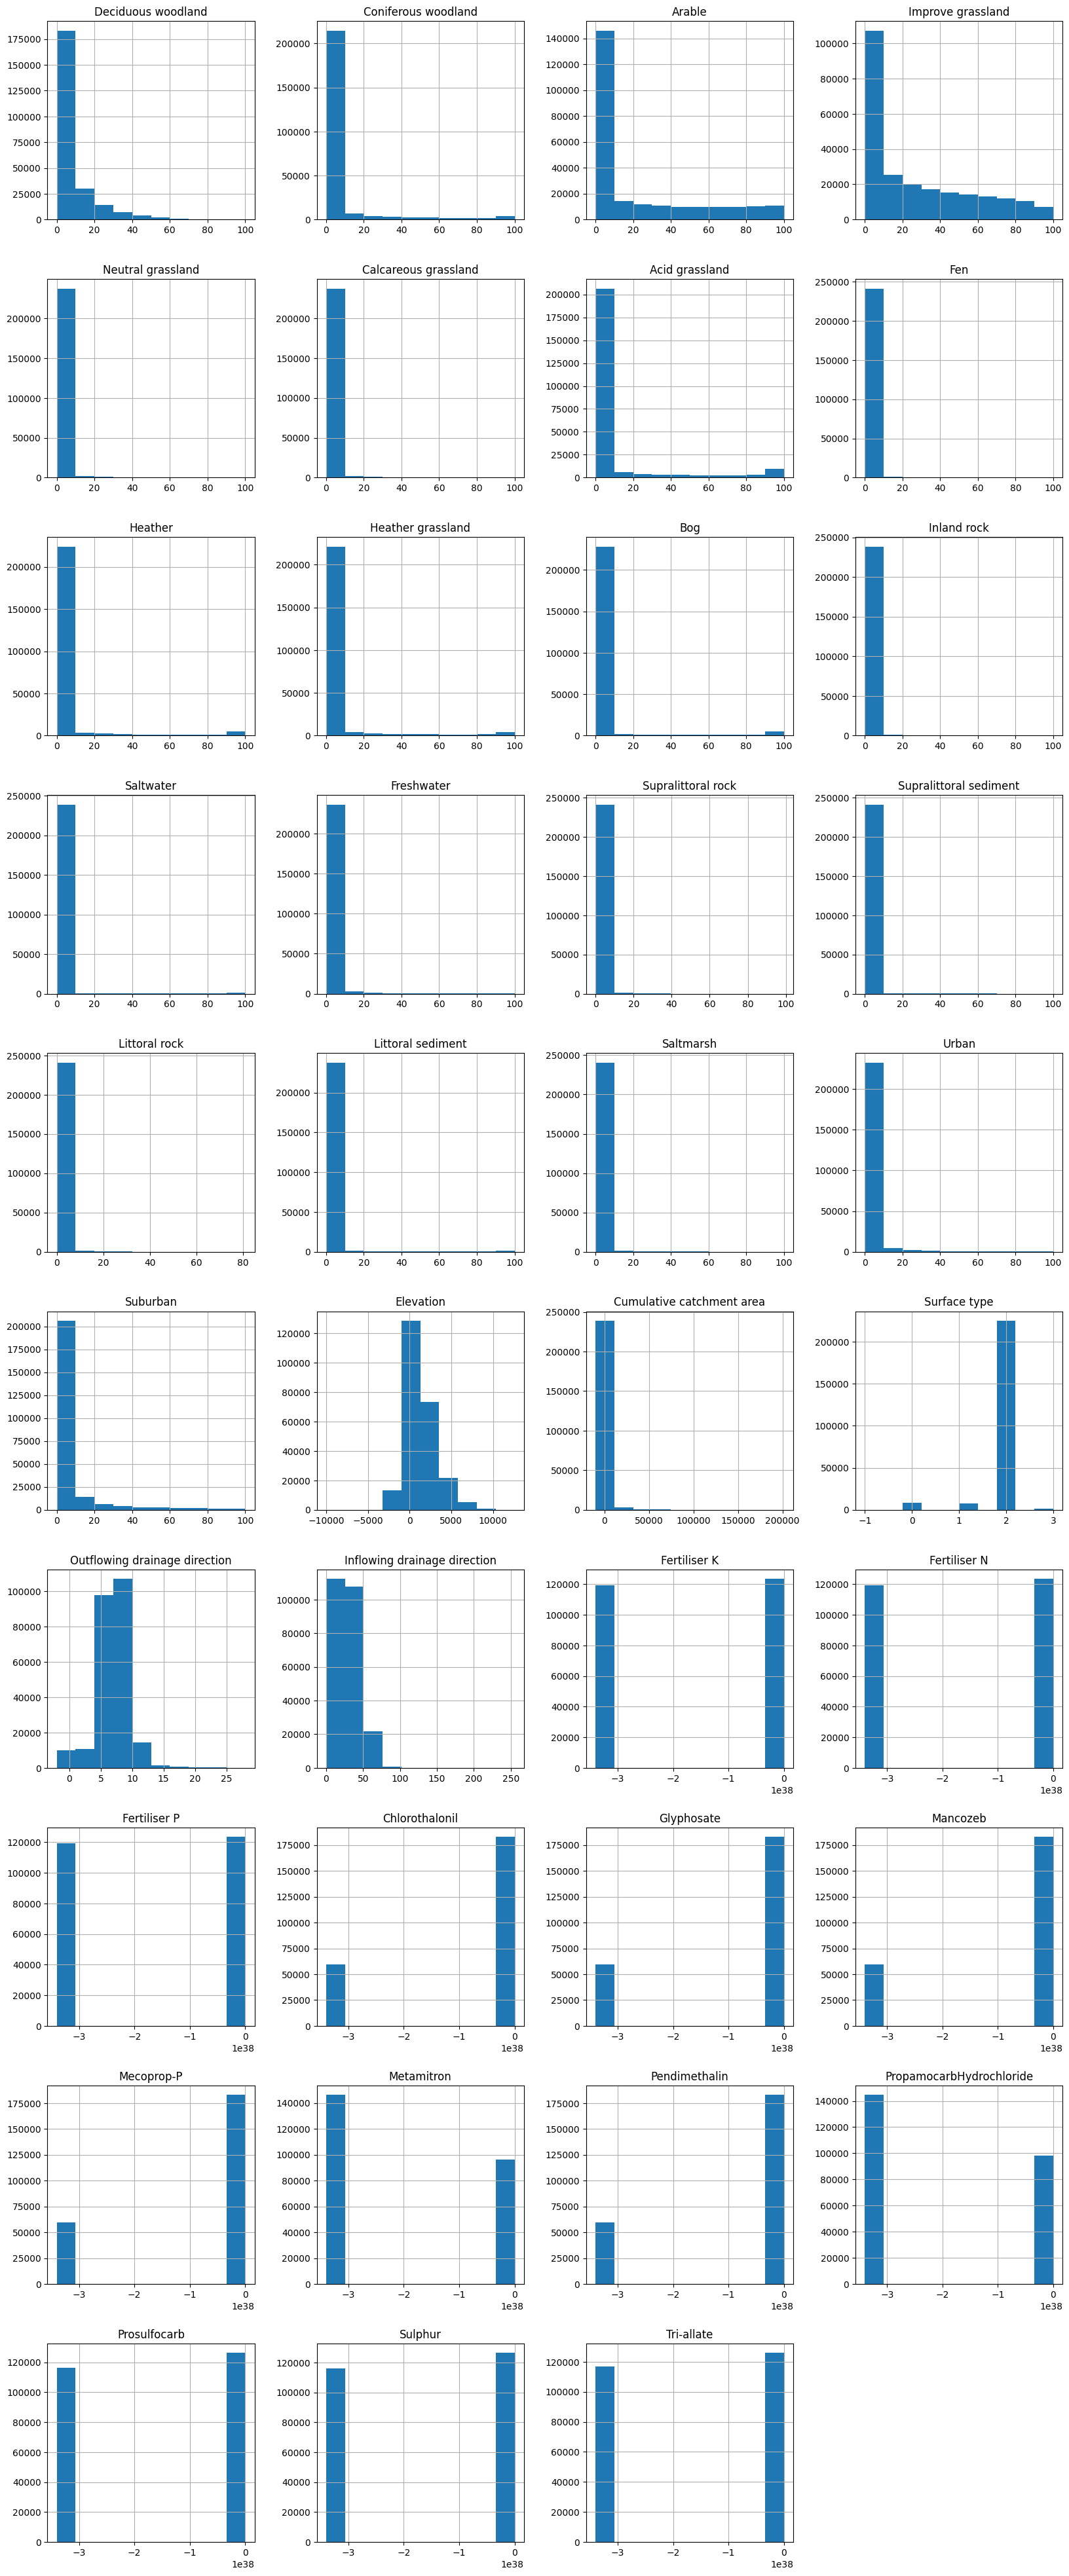

In [ ]:
# Plot distribution of colummns
%matplotlib inline
X.hist(figsize=(20, 50), layout=(10, 4))


array([[<AxesSubplot: title={'center': 'Deciduous woodland'}>,
        <AxesSubplot: title={'center': 'Coniferous woodland'}>,
        <AxesSubplot: title={'center': 'Arable'}>,
        <AxesSubplot: title={'center': 'Improve grassland'}>],
       [<AxesSubplot: title={'center': 'Neutral grassland'}>,
        <AxesSubplot: title={'center': 'Calcareous grassland'}>,
        <AxesSubplot: title={'center': 'Acid grassland'}>,
        <AxesSubplot: title={'center': 'Fen'}>],
       [<AxesSubplot: title={'center': 'Heather'}>,
        <AxesSubplot: title={'center': 'Heather grassland'}>,
        <AxesSubplot: title={'center': 'Bog'}>,
        <AxesSubplot: title={'center': 'Inland rock'}>],
       [<AxesSubplot: title={'center': 'Saltwater'}>,
        <AxesSubplot: title={'center': 'Freshwater'}>,
        <AxesSubplot: title={'center': 'Supralittoral rock'}>,
        <AxesSubplot: title={'center': 'Supralittoral sediment'}>],
       [<AxesSubplot: title={'center': 'Littoral rock'}>,
       

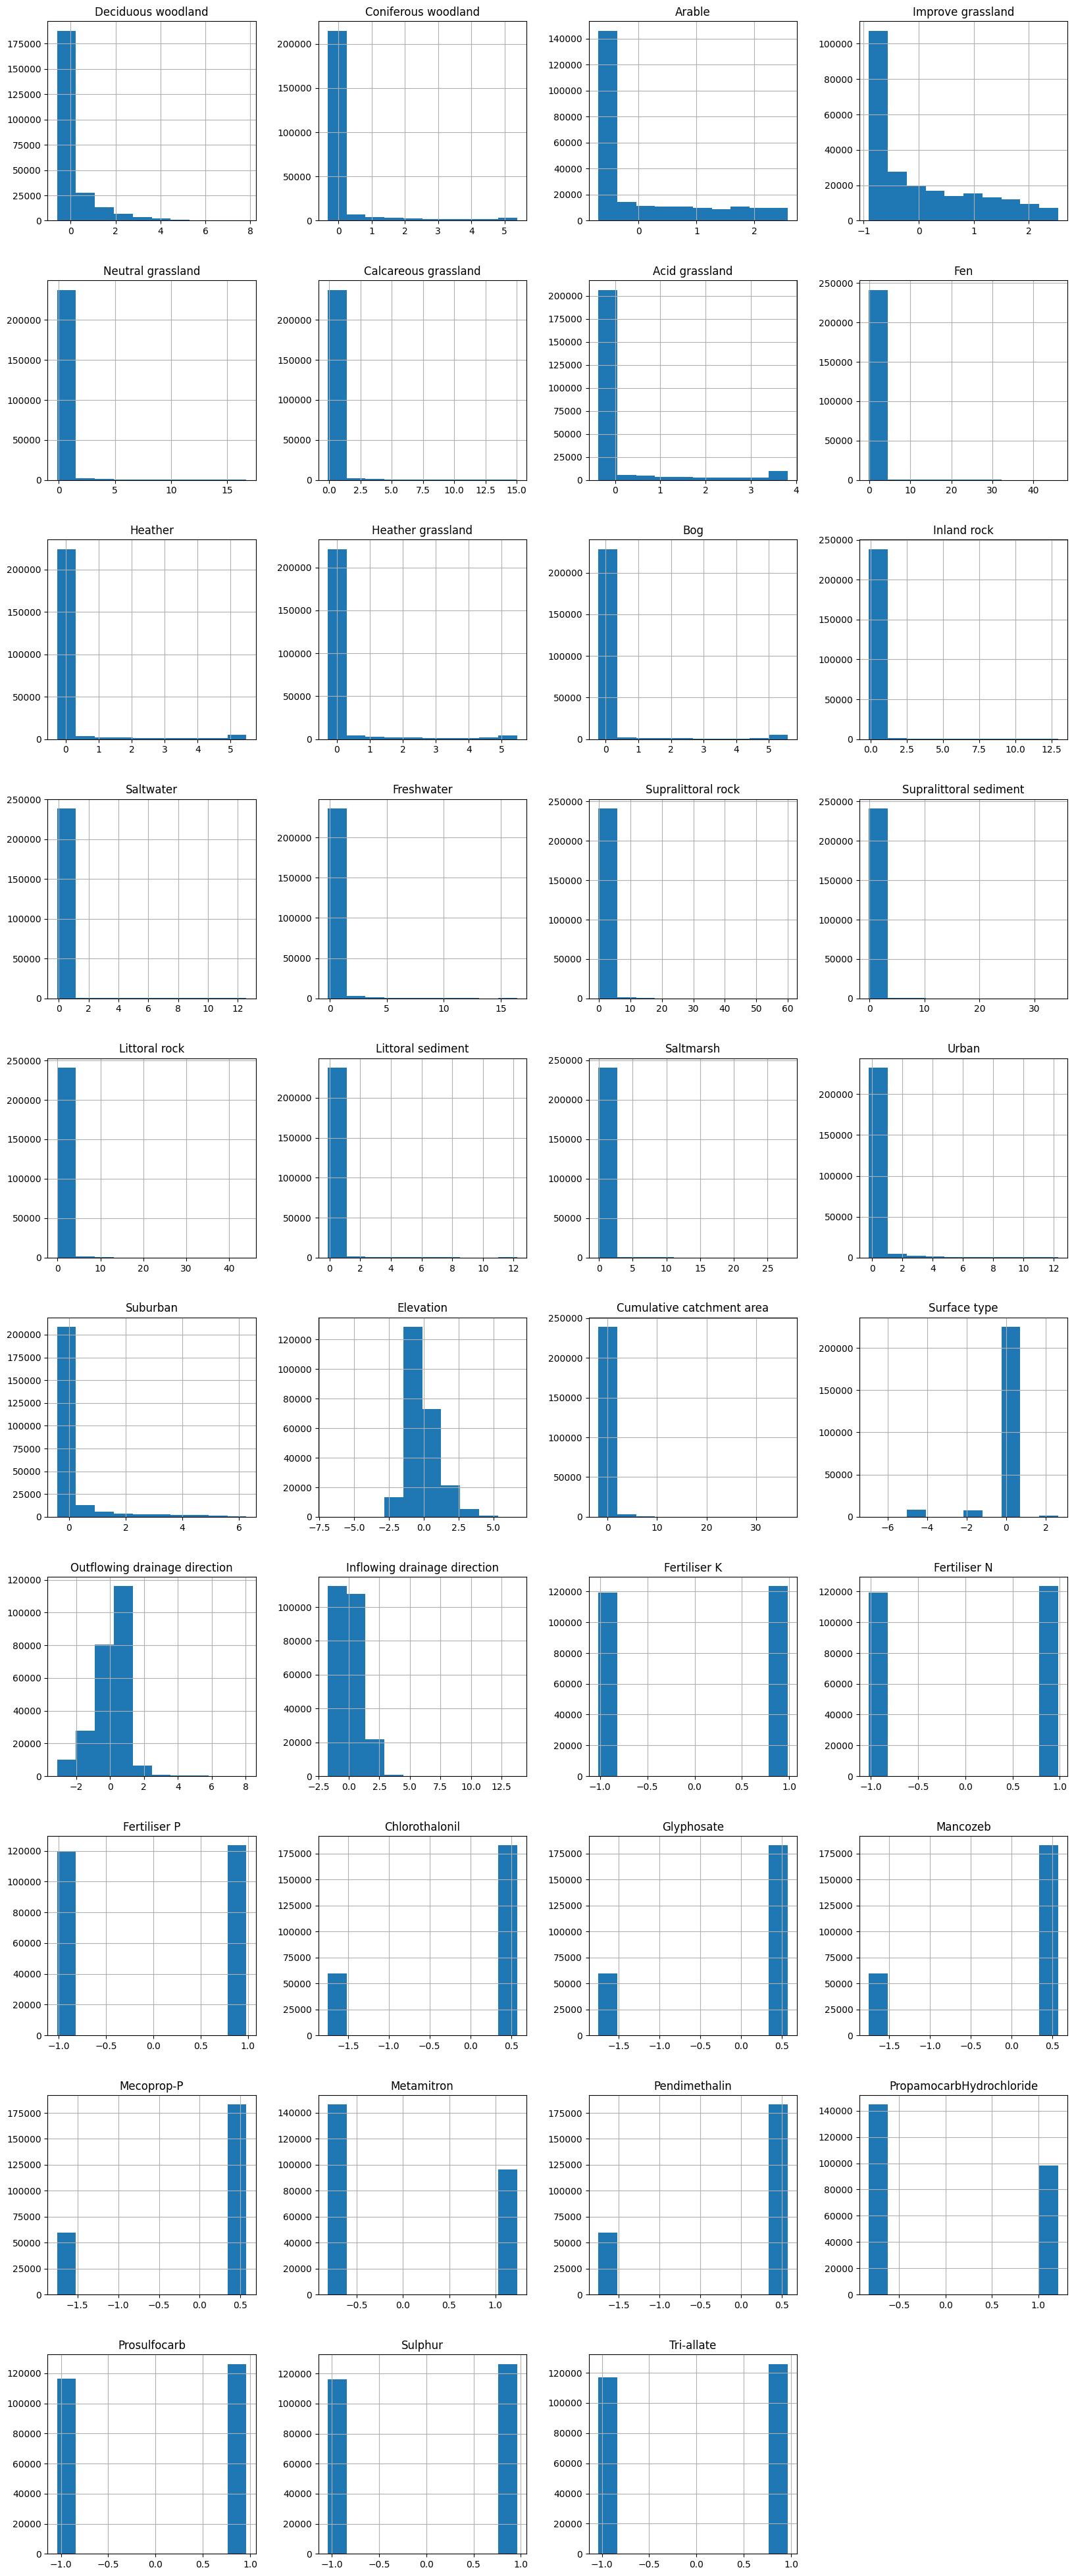

In [ ]:
X_scaled_df.hist(figsize=(20, 50), layout=(10, 4))